## Creation of knockoffs from Spec2Vec embeddings


load files with spectra, put your own path

In [2]:
import numpy as np
import os
import sys
from matchms.importing import load_from_json
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument

folder_name = 'C:\\Users\\Honza\\Desktop'
json_file_name = r'C:\Users\Honza\Documents\gnps_positive_ionmode_cleaned_by_matchms_and_lookups.json'
sys.path.append(os.path.join(folder_name,'FDR-new', 'src'))


In [3]:
spectrums = load_from_json(json_file_name)
print(len(spectrums))
spectrums = [s for s in spectrums if s.metadata.get('inchikey')]
print(len(spectrums))

112956
92954


In [11]:
def peaks(s):
    return ','.join( ('%.2f' % p) for p in s.peaks[0])

In [12]:
# Remove duplicate peaks
specs_by_peaks = {}
for s in spectrums:
    specs_by_peaks[peaks(s)] = s

In [13]:
print(len(specs_by_peaks))

87873


Creating a mapping of the inchi key prefixes to the spectrums in order to identify matching spectra

In [15]:
from matchms.filtering import normalize_intensities
# Spec2Vec trained model requires normalizing
spectrums = [normalize_intensities(s) for s in specs_by_peaks.values()]
del specs_by_peaks

In [20]:
inchi_dict = {}
for s in spectrums:
    ik = s.metadata['inchikey']
    init_ik = ik.split('-')[0]
    if not init_ik in inchi_dict:
        inchi_dict[init_ik] = [s]
    else:
        inchi_dict[init_ik].append(s)

Dividing the spectra into library and queries

In [21]:
query_size = 1000

Building the library with matching queries plus noise

In [22]:
# choosing queries from multis ensures a possible true match
multis = set([i for i,v in inchi_dict.items() if len(v) > 1])

matching_keys = np.random.choice(list(multis), size=query_size, replace=False)

query_spec = {}
spectrums_lib = []
# We select query_size queries that have at least 1 matching spectrum in the library
for q in matching_keys:
    spec_to_add = np.random.choice(inchi_dict[q], size=1, replace=False)
    query_spec[spec_to_add[0].metadata['spectrum_id']] = spec_to_add[0]

# And everything else goes into the library
for s in spectrums:
    if s.metadata['spectrum_id'] not in query_spec:
        spectrums_lib.append(s)

spectrums_query = list(query_spec.values())

Create spectrum "documents"

In [23]:
documents_query = [SpectrumDocument(s, n_decimals=2) for s in spectrums_query]
documents_lib = [SpectrumDocument(s, n_decimals=2) for s in spectrums_lib]

Load pretrained model

In [24]:
import gensim
model_file = os.path.join('C:\\Users\\Honza\\Documents\\trained_models_final\\spec2vec_size_75.model')
model = gensim.models.Word2Vec.load(model_file)

In [25]:
from tqdm.notebook import tqdm  # optional, just to get a progress bar
from spec2vec.vector_operations import calc_vector

intensity_weighting_power = 0.5
allowed_missing_percentage = 15 # specify the maximum (weighted) fraction of the spectrum that is allowed to be missing

vector_size = model.vector_size
print(f"Embedding vector size: {vector_size}")

embeddings_spec2vec_query = np.zeros((len(documents_query), vector_size), dtype="float")
#for i, doc in enumerate(tqdm(documents_query)):
for i, doc in enumerate(documents_query):
    embeddings_spec2vec_query[i, 0:vector_size] = calc_vector(model, doc,
                                                        intensity_weighting_power,
                                                        allowed_missing_percentage)
embeddings_spec2vec_lib = np.zeros((len(documents_lib), vector_size), dtype="float")
#for i, doc in enumerate(tqdm(documents_lib)):
for i, doc in enumerate(documents_lib):
    embeddings_spec2vec_lib[i, 0:vector_size] = calc_vector(model, doc,
                                                        intensity_weighting_power,
                                                        allowed_missing_percentage)

Embedding vector size: 75


In [26]:
from cosine_calc import get_spec2vec_hits

hits = get_spec2vec_hits( documents_query, documents_lib, model, precursor_tol=3,
                          intensity_weighting_power=intensity_weighting_power,
                          allowed_missing_percentage=allowed_missing_percentage, passatutto=False,
                          embeddings_query=embeddings_spec2vec_query, embeddings_library=embeddings_spec2vec_lib) 

In [27]:
# Calculating true q-value scores
from q_value_calc import calculate_q_value
q_list_true = calculate_q_value(hits)

## Creation of knockoffs

In [ ]:
from knockoffs import generate_knockoffs
q_list_knockoffs = {}

knockoff_documents = generate_knockoffs(model,documents_lib,allowed_missing_percentage=allowed_missing_percentage,
                                        n_components=5, diagonal_matrix=45)
hits_knockoffs = get_spec2vec_hits(documents_query, knockoff_documents, decoys=True, model=model, precursor_tol=3,
                                   intensity_weighting_power=intensity_weighting_power,
                                   allowed_missing_percentage=allowed_missing_percentage,
                                   embeddings_query=embeddings_spec2vec_query, passatutto=False)
q_list_knockoffs["knockoff"] = calculate_q_value(hits+hits_knockoffs,True)

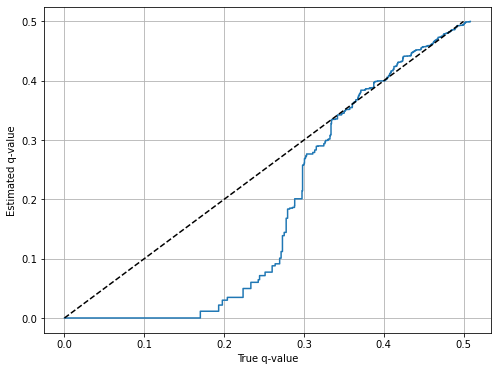

In [44]:
import plot_q_vals

plot_q_vals.plot_q_vals( q_list_true, q_list_knockoffs, labels=False )

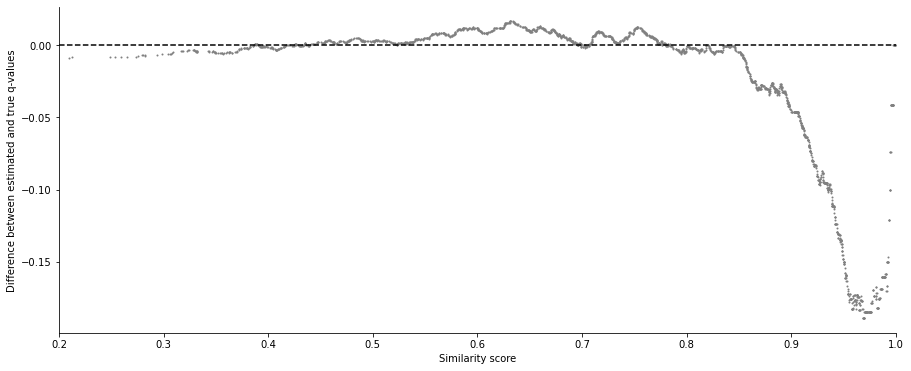

In [42]:
import pylab as plt
    
# plot estimated and true q-values
def combine_true_est_2(q_val_true,q_val_est):
    res = []
    q_idx = 0
    for q_e, _, score in q_val_est:
        while q_idx < len(q_val_true)-1 and q_val_true[q_idx+1][2] >= score:
            q_idx += 1
        res.append((score, q_e-q_val_true[q_idx][0]))
    return res

def plot_q_vals3(trues, knockoffs):
    fig, ax = plt.subplots(figsize=(15,6))
    for label, knockoff in knockoffs.items():
            scores, ys = zip(*combine_true_est_2(q_list_true, knockoff))
            plt.plot(scores,ys, 'o', color='gray', markersize=1, label=label)
    plt.plot([0.2,1.0], [0,0], 'k--')
    plt.xlabel('Similarity score')
    plt.ylabel('Difference between estimated and true q-values')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlim([0.2, 1.0])
         
    
plot_q_vals3(q_list_true,q_list_knockoffs)

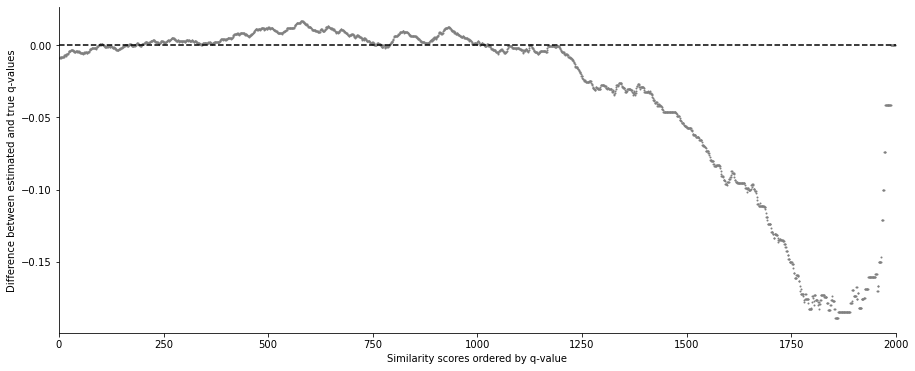

In [43]:
def combine_true_est(q_val_true,q_val_est):
    res = []
    q_idx = 0
    for q_e, _, score in q_val_est:
        while q_idx < len(q_val_true)-1 and q_val_true[q_idx+1][2] >= score:
            q_idx += 1
        res.append((score, q_val_true[q_idx][0], q_e))
    return res

def plot_q_vals2(estimated, filename=None):
    fig, ax = plt.subplots(figsize=(15,6))

    tru, est = to_plot['knockoff']
    plt.plot(range(len(tru),0,-1), [e-t for t,e in zip(tru,est)], 'o', color='gray', markersize=1)
    plt.plot([0,2000], [0,0], 'k--')
    plt.xlabel('Similarity scores ordered by q-value')
    plt.ylabel('Difference between estimated and true q-values')
    if filename is not None:
        plt.savefig(filename)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlim([0, 2000])

to_plot = {}
for k,v in q_list_knockoffs.items():
    to_plot[k] = list(zip(*combine_true_est(q_list_true, v)))[1], list(zip(*combine_true_est(q_list_true, v)))[2]
    
plot_q_vals2( to_plot )

In [45]:
tru,est = to_plot['knockoff']
vals = [ abs(e-t) for t,e in zip(tru,est) ]

print("avg error:", sum(vals) / 2000 )
print("avg error for 75% dataset", sum(vals[500:]) / 1500 )
print("avg error for 66% dataset", sum(vals[666:]) / 1333 )

scores, ys = zip(*combine_true_est_2(q_list_true, q_list_knockoffs['knockoff']))
print("75% hits have score below", scores[500])
print("66% hits have score below", scores[666])

avg error: 0.03941489409170149
avg error for 75% dataset 0.010262118367008676
avg error for 66% dataset 0.00680595614613576
75% hits have score below 0.9103025474196703
66% hits have score below 0.8801666317838543
